In [1]:
import cv2
import numpy as np
import pandas as pd
import sys
from PIL import Image
from image_foveation import foveat_img

import matplotlib.pyplot as plt
%matplotlib inline

scene_image = np.array(Image.open('./images/original/ADE_train_00010429.jpeg'))
scene_image.shape

(400, 600, 3)

In [2]:
import cv2

im_path = './images/original/ADE_train_00010429.jpeg'
im = np.array(Image.open(im_path))

# xc, yc = 550, 120
xc, yc = int(im.shape[1]/4), int(im.shape[0]/2)
im = foveat_img(im, [(xc, yc)], sigma=0.4)

cv2.imwrite('RT.jpg', im)

num of full-res pixel 97


True

In [3]:
objectinfo150_path = "./ADEChallengeData2016/objectInfo150.txt"
df = pd.read_csv(objectinfo150_path, delimiter = "\t")

display(df.head())

,Idx,Ratio,Train,Val,Name
0,1,0.1576,11664,1172,wall
1,2,0.1072,6046,612,"building, edifice"
2,3,0.0878,8265,796,sky
3,4,0.0621,9336,917,"floor, flooring"
4,5,0.0480,6678,641,tree


(400, 600, 3)
(400, 600)
[  0   1   4   6   9  11  15  20  45  48  64  68  74  83  90 130 134 143]
num of full-res pixel 97


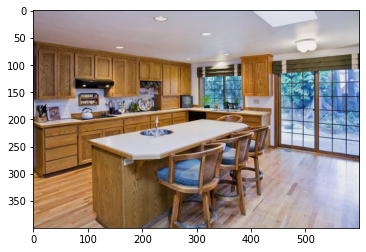

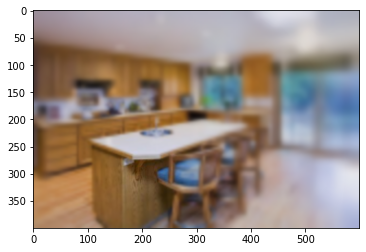

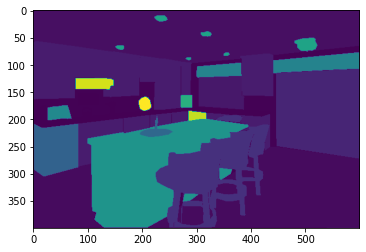

0 []
1 ['wall']
4 ['floor, flooring']
6 ['ceiling']
9 ['windowpane, window ']
11 ['cabinet']
15 ['door, double door']
20 ['chair']
45 ['chest of drawers, chest, bureau, dresser']
48 ['sink']
64 ['blind, screen']
68 ['book']
74 ['kitchen island']
83 ['light, light source']
90 ['television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box']
130 ['dishwasher, dish washer, dishwashing machine']
134 ['hood, exhaust hood']
143 ['plate']


In [4]:
im_path = './ADEChallengeData2016/images/training/ADE_train_00010429.jpg'
an_path = im_path.replace("images", "annotations").replace("jpg", "png")

im = np.array(Image.open(im_path))
an = np.array(Image.open(an_path))

print(im.shape)
print(an.shape)

print(np.unique(an))
xc, yc = im.shape[0]/2, im.shape[1]/2
fv = foveat_img(im, [(xc, yc)], sigma=0.4)


plt.imshow(im)
plt.show()
plt.imshow(fv)
plt.show()
plt.imshow(an)
plt.show()

for idx in np.unique(an):
    print(idx, df[df["Idx"] == idx]["Name"].values)

(512, 683, 3)
(512, 683)
[  0   1   4   6  15  18  20  23  46  65 126]
num of full-res pixel 1


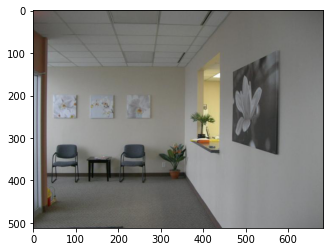

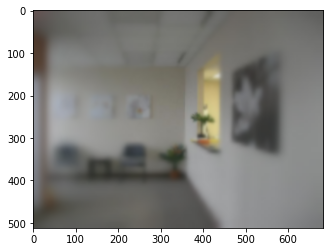

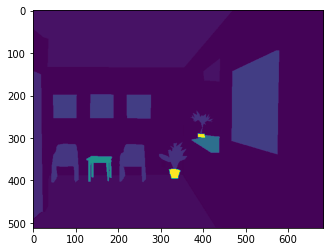

0 []
1 ['wall']
4 ['floor, flooring']
6 ['ceiling']
15 ['door, double door']
18 ['plant, flora, plant life']
20 ['chair']
23 ['painting, picture']
46 ['counter']
65 ['coffee table, cocktail table']
126 ['pot, flowerpot']


In [5]:
im_path = './ADEChallengeData2016/images/training/ADE_train_00019690.jpg'
an_path = im_path.replace("images", "annotations").replace("jpg", "png")

im = np.array(Image.open(im_path))
an = np.array(Image.open(an_path))

print(im.shape)
print(an.shape)

print(np.unique(an))
xc, yc = 350, 220
fv = foveat_img(im, [(xc, yc)], sigma=0.5)


plt.imshow(im)
plt.show()
plt.imshow(fv)
plt.show()
plt.imshow(an)
plt.show()

for idx in np.unique(an):
    print(idx, df[df["Idx"] == idx]["Name"].values)

In [6]:
from environment import AfcEnv

env = AfcEnv()

num of full-res pixel 104


In [5]:
import cv2
import numpy as np

import gym
from gym import error, spaces, utils
from gym.utils import seeding

from PIL import Image
from scipy.stats import multivariate_normal
from image_foveation import foveat_img


class AfcEnv(gym.Env):
    """
    Artificial Forvia Control
    action: 
    observation: RGB images ()
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        im_path = './ADEChallengeData2016/images/training/ADE_train_00019690.jpg'
        an_path = im_path.replace("images", "annotations").replace("jpg", "png")
        
        self.im = np.array(Image.open(im_path))
        self.an = np.array(Image.open(an_path))

        self.observation_space = spaces.Box(0, 255, shape=self.im.shape)
        self.action_space = spaces.Box(low=-10, high=10, shape=(2,))
        # self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        
        self.WINDOW_SIZE = 600 #画面サイズの決定
        self.TIME_STEP = 0
        self.reset()
        
    def reset(self):
        # 状態を初期化し、初期の観測値を返す
        self.fixs = np.array([self.im.shape[0]/2, self.im.shape[1]/2])
        observation = foveat_img(self.im, [self.fixs], sigma=0.4)        
        return observation

    def step(self, action): 
        # actionを実行し、結果を返す
        """
        """
        self.TIME_STEP += 1
        sd = 0.5
        self.fixs += action
        observation = foveat_img(self.im, [self.fixs], sigma=0.4)        
        reward = self.reward(self.fixs, sd, label=23)

        if self.TIME_STEP > 100:
            done = True
        else:
            done = False

        print(action, self.fixs) # for debug
        
        return observation, reward, done, {}
        
    def render(self, mode='human', close=False):
        # 環境を可視化する
        # mg = np.zeros((self.WINDOW_SIZE, self.WINDOW_SIZE, 3)) #画面初期化
        img = foveat_img(self.im, [self.fixs], sigma=0.7)        
        cv2.imshow('image', img)
        cv2.waitKey(1)

    def close(self):
        # 環境を閉じて後処理をする
        pass

    def seed(self, seed=None): 
        # ランダムシードを固定する
        pass

    def reward(self, fixs, sd, label=23):
        F = multivariate_normal(mean=fixs, cov=[[sd**2, 0.0],[0.0,sd**2]])
        reward = 0.0
        xx, yy = np.where(self.an == label)
        for (x, y) in zip(xx, yy):
            r = F.pdf([x,y])
            reward += r
        return reward

In [ ]:
env = AfcEnv()

observation = env.reset()
for _ in range(10000):
    env.render(mode="rgb_array")
    action = env.action_space.sample() # random action
    observation, reward, done, _ = env.step(np.array([1,1]))
    # observation, reward, done, _ = env.step(env.action_space.sample())

    if done:
        env.reset()

num of full-res pixel 104
num of full-res pixel 104
num of full-res pixel 0
num of full-res pixel 104
[1 1] [257.  342.5]
num of full-res pixel 0
num of full-res pixel 104
[1 1] [258.  343.5]
num of full-res pixel 0
num of full-res pixel 104
[1 1] [259.  344.5]
num of full-res pixel 0
num of full-res pixel 104
[1 1] [260.  345.5]
num of full-res pixel 0
num of full-res pixel 104
[1 1] [261.  346.5]
num of full-res pixel 0
num of full-res pixel 104
[1 1] [262.  347.5]
num of full-res pixel 0
num of full-res pixel 104


In [106]:
from scipy.stats import multivariate_normal

def reward(fixs, sd, annotation_image, label=23):
    reward = 0.0
    F = multivariate_normal(mean=fixs, cov=[[sd**2, 0.0],[0.0,sd**2]])
    xx, yy = np.where(annotation_image == label)
    for (x, y) in zip(xx, yy):
        r = F.pdf([x,y])
        reward += r
        # print(x, y, r)
            
    return reward

fixs=(95,571)
sd=1.0
r = reward(fixs, sd, an, label=23)

In [107]:
r

0.6761094679766518

In [44]:
from scipy.stats import multivariate_normal

var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

0.09653235263005393

In [43]:
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

0.09653235263005393

In [51]:
fixs=(0,0)
sd=1.0
var = multivariate_normal(mean=fixs, cov=[[sd**2, 0.0],[0.0,sd**2]])
var.pdf([1,0])

0.09653235263005393

<ipython-input-52-5380f728cc18>:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


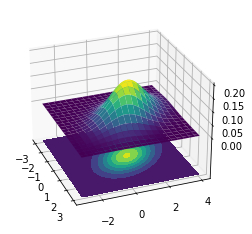

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()